In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
pd.options.display.float_format = '{:.0f}'.format
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
plt.style.use('seaborn-white')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
#Прочитаем данные
df = pd.read_csv('01_data.csv',sep=';' )
df2 = pd.read_csv('02_etalon.csv',sep=';')

# Переведем формат даты
df['fulldate'] = pd.to_datetime(df['fulldate'])
# Отделим датасет на 2 части по датам
df['target'] =  np.where(df['fulldate']<'2018-09-15', 0, 1)
#Создадим переменную new как сочетание lac и cid
df['new'] = df['lac'].astype(str) + df['cid'].astype(str)

df['time'] = pd.to_datetime(df['ts'].apply(lambda x: datetime.fromtimestamp(x))) # переводим unix в формат времени
# считаем время сколько hash id проводит на одной локации (lac) в поле spent
df['one1'] = pd.to_datetime(df.groupby(['hash_id'])['time'].diff()) # считаем разницу времени нахождения в одной точке
df['spent'] = (df['one1'].dt.day - 1) * 24 * 60 + df['one1'].dt.hour * 60 + df['one1'].dt.minute # переводим в минуты
del df['one1']

In [3]:
# Для удобства создадим таблицу поменьше
big = df[['hash_id', 'new', 'spent']]

# Создадим вектор перемещений клиентов
cross = pd.crosstab(big['hash_id'], big['new'], values=big['spent'], aggfunc='sum')
cross = cross.fillna(0) # заполним пропуски нулями, тк клиент не был в этих точках

In [4]:
cross.head()

new,2311181409041,2311181409042,2311181411345,2312081530129,2313081420817,2313081420819,2313181542417,2314181513233,330220604,330221645,...,997654017,997654785,997654786,997660417,997660418,997660419,997660421,997663747,997663750,997663776
hash_id,,,,,,,,,,,,,,,,,,,,,
1000773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Для ускорения процесса и снижения потребления памяти созданим sparse матрицу
sparse = csr_matrix(cross)

# Посичтаем косинусную близость по векторам перемещения клиентов
dist_out = 1-pairwise_distances(sparse, metric="cosine")

# Создадим датафрейм и проименуем столбцы и индекы именами hash_id
cos = pd.DataFrame(dist_out)
cos.index = cross.index.astype(str).tolist()
cos.columns = cross.index.astype(str).tolist()


In [6]:
cos.head()

,1000773,1000808,1000868,1001103,1001168,1001966,1002185,1005142,1005192,1006406,...,2996085,2996296,2996872,2997680,2998492,2998617,2999034,2999248,2999753,2999841
1000773,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000808,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000868,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001103,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001168,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Чтобы ничего не сломалось скопируем датафрейм
cos1 = cos.copy()

df['hash_id'] =  df['hash_id'].astype(str)
# создадим hash_id из первой половины месяца и из второй
target0 = df[df['target']==0]['hash_id'].unique().tolist()
target1 = df[df['target']==1]['hash_id'].unique().tolist()


In [8]:
# Отбираем в индексах первый период, в столбцах 2 период
cos_fin = cos1[cos1.index.isin(target0)]
cos_fin = cos_fin[target1]

In [9]:
cos_fin.head()

,2695335,2458905,2730453,2539971,2712514,2576814,2412747,2586409,2749134,2095380,...,2965099,2967374,2664544,2002889,2380405,2604945,2929171,2068565,2533332,2241318
1000773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Создадим функцию для вытаскивания имени столбца при максимальном значении в строке 
# Ищем максимально значение по строке и вытаскиваем имя из столбца 
# Значение из индекса + значение столбца с максимальным значением косинусной близости = необходимая пара 
def returncolname(row, colnames):
    return colnames[np.argmax(row.values)]

max_cross = cos_fin.apply(lambda x: returncolname(x, cos_fin.columns), axis=1)

max_cross = pd.DataFrame(max_cross).reset_index()
max_cross.columns = 'id1', 'id2'

max_cross['id1'] = max_cross['id1'].astype(str)
df2['id1'] = df2['id1'].astype(str)

max_cross.head()

,id1,id2
0,1000773,2538498
1,1000808,2884143
2,1000868,2699292
3,1001103,2616350
4,1001168,2038453


In [12]:
# Мерджим проверочный датасет и получившийся датасет 
to_check = df2.merge(max_cross, on = 'id1', how = 'left')

to_check['id2_x'] = to_check['id2_x'].astype(str)
to_check['id2_y'] = to_check['id2_y'].astype(str)

# Считаем долю верных  и не верных ответов
num_right = (len(to_check[to_check['id2_x'] == to_check['id2_y']]) * 100. / len(df2) ) 
num_wrong = (len(to_check[to_check['id2_x'] != to_check['id2_y']]) * 100. / len(df2) ) 

#print(f' Доля верных ответов {num_right} ')
#print(f' Доля не верных ответов {num_wrong} ')
print 'Total in test =', len(df2) 
print 'Share of right answers =', int(num_right), '%' 
print 'Share of wrong answers =',  int(num_wrong), '%'

Total in test = 491
Share of right answers = 83 %
Share of wrong answers = 16 %


In [13]:
# Проверим те ответы, в которых мы ошиблись. Проверку попробуем проести следующим образом. Создадим поле new - это
# соединение lac и cid. Сгруппируем по ним и посчитаем количество времени проведенного на каждой такой точке new.

df = df.sort_values(by = ['hash_id', 'ts'], ascending=[True, True]) # Сортируем по хэшу и времени
df['rn2'] = df.groupby(['hash_id', 'new']).cumcount() + 1 # нумеруем строки 

df1 = df.copy() 
#df1 = df[df['isweekend']==0]
df1 = df1[['hash_id', 'spent', 'new', 'rn2']]
df11 = df1.groupby(['hash_id', 'new', 'rn2'])['spent'].count().reset_index()
df12 = df1.groupby(['hash_id', 'new', 'rn2'])['spent'].sum().reset_index()
df11['spent_sum'] = df12['spent']

df12 = df11.groupby(['hash_id', 'new'])['spent'].sum().reset_index()
df13 = df11.groupby(['hash_id', 'new'])['spent_sum'].sum().reset_index()
df12['spent_sum'] = df13['spent_sum']

df12.head()

,hash_id,new,spent,spent_sum
0,1000773,50074881,1,4466
1,1000773,500752985,1,9601
2,1000773,500761922,1,8
3,1000773,500762117,1,10144
4,1000773,500762166,1,2976


In [14]:
# Создадим переменные где мы ошиблись и где были правы.
check_wrong = to_check[to_check['id2_x'] != to_check['id2_y']]
check_right = to_check[to_check['id2_x'] == to_check['id2_y']]

# Сделаем проверку: Возьмем топ10 посещаемых мест по времени пребывания. и посмотрим сколько из топ10 пересекается
cross_values_wrong=[]
for i in range(len(check_wrong)):
    first  = df12[df12['hash_id'].isin([check_wrong.iloc[i][0]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['new'].tolist()
    second = df12[df12['hash_id'].isin([check_wrong.iloc[i][1]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['new'].tolist()
    # Оставим пересекажщиеся маршруты new из топ10
    cross_values_wrong.append(len(set.intersection(set(first),set(second))))
    

cross_values_right=[]
for i in range(len(check_right)):
    first  = df12[df12['hash_id'].isin([check_right.iloc[i][0]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['new'].tolist()
    second = df12[df12['hash_id'].isin([check_right.iloc[i][1]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['new'].tolist()
    cross_values_right.append(len(set.intersection(set(first),set(second))))

In [15]:
num = np.arange(11)
wrong = np.array([cross_values_wrong.count(0), cross_values_wrong.count(1), cross_values_wrong.count(2), cross_values_wrong.count(3), cross_values_wrong.count(4), cross_values_wrong.count(5), cross_values_wrong.count(6), cross_values_wrong.count(7), cross_values_wrong.count(8), cross_values_wrong.count(9), cross_values_wrong.count(10)]) *100. / len(check_wrong)
right = np.array([cross_values_right.count(0), cross_values_right.count(1), cross_values_right.count(2), cross_values_right.count(3), cross_values_right.count(4), cross_values_right.count(5), cross_values_right.count(6), cross_values_right.count(7), cross_values_right.count(8), cross_values_right.count(9), cross_values_right.count(10) ])*100. / len(check_right)

# Построим таблицу , сколько % 
share = pd.DataFrame(wrong, right).reset_index()
share.index = num
share.columns =  'right', 'wrong'

pd.options.display.float_format = '{:,.0f}%'.format
share

,right,wrong
0,0%,23%
1,0%,12%
2,4%,12%
3,5%,17%
4,11%,15%
5,13%,10%
6,20%,5%
7,16%,2%
8,19%,4%
9,10%,0%


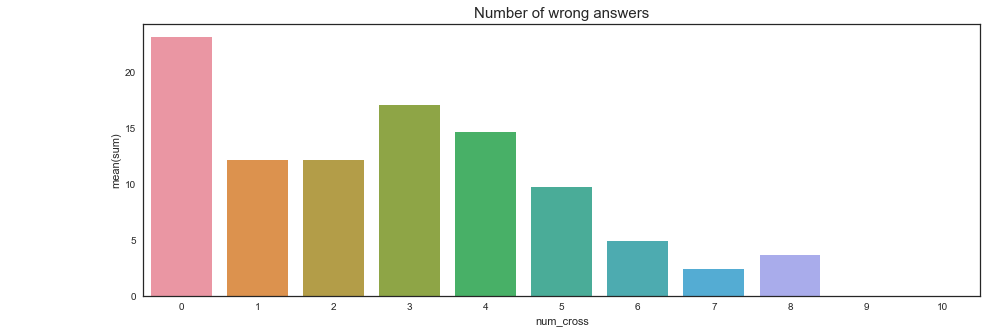

In [16]:
# График Не правильных ответов
p = pd.DataFrame(wrong,num).reset_index()
p.columns =  'num_cross', 'sum'

ax = sns.barplot(x=p['num_cross'], y=p['sum'])
ax.set_title('Number of wrong answers', size=15)

num1 = [x - 1 for x in num]
for p, c in zip(num1, wrong):
    plt.annotate(str(c), xy=(p, 40), va='center', fontweight='bold')

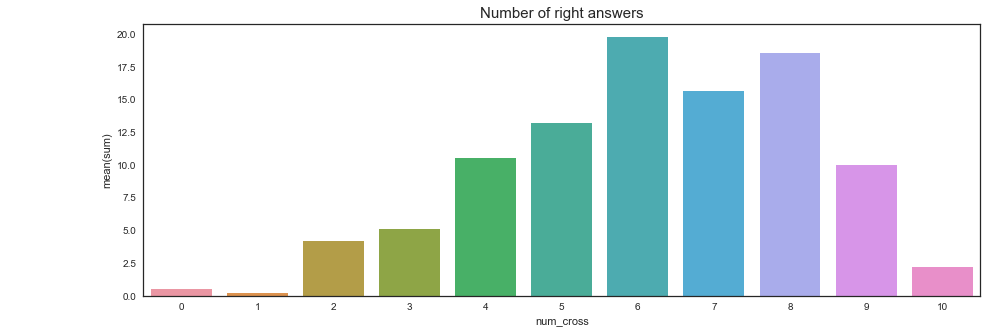

In [17]:
# График Правильных ответов
p = pd.DataFrame(right,num).reset_index()
p.columns =  'num_cross', 'sum'

ax = sns.barplot(x=p['num_cross'], y=p['sum'])
ax.set_title('Number of right answers', size=15)
num1 = [x - 1 for x in num]
for p, c in zip(num1, right):
    plt.annotate(str(c), xy=(p, 40), va='center', fontweight='bold')

In [18]:
pd.options.display.max_rows = len(max_cross)
#Финальная таблица:
max_cross

,id1,id2
0,1000773,2538498
1,1000808,2884143
2,1000868,2699292
3,1001103,2616350
4,1001168,2038453
5,1001966,2488689
6,1002185,2363276
7,1005142,2461863
8,1005192,2764090
9,1006406,2594531


### Таким образом, мы ошибаемся в 16% случаев,  при этом эти клиенты (в которых ошиблись) имеют мало пересечений по топ10 посещаемых точек. И их распределение сдвинуто в сторону 0, а тех, кого мы нашли - в сторону 8 из 10.

Так же пробовал подход делать не с временем на каждой точке , а просто с count. Результат получился одинаковый. Пробовал еще следующий подход . Но он очень сильно ошибался. Подход был основан на выборе ТОП n мест по времени пребываний. а места это маршруты из 2 и 3 точек

In [ ]:
# считаем время сколько hash id проводит на одной локации (lac) в поле spent
df['one1'] = pd.to_datetime(df.groupby(['hash_id'])['time'].diff()) # считаем разницу времени нахождения в одной точке
df['spent'] = (df['one1'].dt.day - 1) * 24 * 60 + df['one1'].dt.hour * 60 + df['one1'].dt.minute # переводим в минуты
del df['one1']

# Создаем пары и тройки маршрутов
df['lac2'] = df.groupby(['hash_id'])['lac'].shift(-1) # переменная для пары
df['lac3'] = df.groupby(['hash_id'])['lac'].shift(-2) # переменная для тройки

df = df.dropna() # Убираем записи где остались nan ( по 1 - 2 строки из каждого hash_id)

df['lac2'] = df['lac2'].astype(int) # чтобы в следующем действии(в переводе в стр не было '.0' в конце переводим в инт 
df['lac3'] = df['lac3'].astype(int)

df['way_two'] = df['lac'].astype(str) +  df['lac2'].astype(str) # пары маршрутов
df['way_three'] = df['lac'].astype(str) +  df['lac2'].astype(str) +  df['lac3'].astype(str) # тройки маршрутов

del df['lac2'], df['lac3']

In [ ]:
df1 = df.copy() 
#df1 = df[df['isweekend']==0]
df1 = df1[['hash_id', 'spent', 'way_two', 'rn2']]
df11 = df1.groupby(['hash_id', 'way_two', 'rn2'])['spent'].count().reset_index()
df12 = df1.groupby(['hash_id', 'way_two', 'rn2'])['spent'].sum().reset_index()
df11['spent_sum'] = df12['spent']

df12 = df11.groupby(['hash_id', 'way_two'])['spent'].sum().reset_index()
df13 = df11.groupby(['hash_id', 'way_two'])['spent_sum'].sum().reset_index()
df12['spent_sum'] = df13['spent_sum']

a = []
for i in range(len(df2)):
    first  = df12[df12['hash_id'].isin([df2.iloc[i][0]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['way_two'].tolist()
    second = df12[df12['hash_id'].isin([df2.iloc[i][1]])].sort_values(by=['hash_id', 'spent_sum'], ascending = [False, False]).head(10)['way_two'].tolist()
    a.append(len(set.intersection(set(first),set(second))))

...